# Semantic Segmentation using UNET 

## Task

100 frames of pixel-perfect semantic segmentation with 11 classes.

## Dataset Overview:
The 100 frames are taken at every 12th frame (with some blurred frames and outliers replaced) from the match between Real Madrid and Manchester United from open media. The dataset is appropriate for training detection models in respect to sports analytics, of course biased towards soccer.

## What is semantic segmentation 
Segmantion is an computer vision task of partitioning the image into different classes . Semantic Segmentation is the operation where we classifiy every pixel in an image into classes with specific boundaries and shapes.


In [156]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation/Frame 1  (68).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (96).jpg
/kaggle/input/semantic-segmentation/Frame 1  (41).jpg
/kaggle/input/semantic-segmentation/Frame 1  (85).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (41).jpg___save.png
/kaggle/input/semantic-segmentation/Frame 1  (48).jpg
/kaggle/input/semantic-segmentation/Frame 1  (14).jpg___save.png
/kaggle/input/semantic-segmentation/Frame 1  (83).jpg
/kaggle/input/semantic-segmentation/Frame 1  (39).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (47).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (74).jpg
/kaggle/input/semantic-segmentation/Frame 1  (24).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (52).jpg
/kaggle/input/semantic-segmentation/Frame 1  (63).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (18).jpg___fuse.png
/kaggle/input/semantic-segmentation/Frame 1  (72).jpg___save.png
/kaggle/input/semantic-seg

## 1. Import the libraries 

In [1]:
import json
import os
import shutil
import glob
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Input,Conv2DTranspose,concatenate,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

## 2.Import the data 
 
Data link : 
The data consist of set of images in jpg (3 channels) and the masks or labels as we will see in png (4 channels , the forth channel is called the alpha channel that responsible of the opacity of the images).

Dataset :[Semantic Segmentation](https://www.kaggle.com/datasets/mohammednomer/semantic-segmentation)

In [2]:
directory='/kaggle/input/semantic-segmentation'
files=[os.path.join(directory,f) for f in sorted(os.listdir(directory))]

In [3]:
folder_path = '/kaggle/input/semantic-segmentation'

# List all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Get the number of files
num_files = len(files)

print(f'The number of files in the folder is: {num_files}')

The number of files in the folder is: 303


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
directory_path="/kaggle/input/semantic-segmentation"
images_path=sorted(glob.glob(os.path.join(directory_path, '*.jpg')))
masks_path= sorted(glob.glob(os.path.join(directory_path, '*__fuse*.png')))
df=pd.DataFrame(columns=["Images paths","Masks paths"])
df["Images paths"]=images_path
df["Masks paths"]=masks_path
df

Images paths  \
0     /kaggle/input/semantic-segmentation/Frame 1  (1).jpg   
1    /kaggle/input/semantic-segmentation/Frame 1  (10).jpg   
2   /kaggle/input/semantic-segmentation/Frame 1  (100).jpg   
3    /kaggle/input/semantic-segmentation/Frame 1  (11).jpg   
4    /kaggle/input/semantic-segmentation/Frame 1  (12).jpg   
..                                                     ...   
95   /kaggle/input/semantic-segmentation/Frame 1  (95).jpg   
96   /kaggle/input/semantic-segmentation/Frame 1  (96).jpg   
97   /kaggle/input/semantic-segmentation/Frame 1  (97).jpg   
98   /kaggle/input/semantic-segmentation/Frame 1  (98).jpg   
99   /kaggle/input/semantic-segmentation/Frame 1  (99).jpg   

                                                          Masks paths  
0     /kaggle/input/semantic-segmentation/Frame 1  (1).jpg___fuse.png  
1    /kaggle/input/semantic-segmentation/Frame 1  (10).jpg___fuse.png  
2   /kaggle/input/semantic-segmentation/Frame 1  (100).jpg___fuse.png  
3    /kaggle/input/semantic-segmentation/Frame 1  (11).jpg___fuse.png  
4    /kaggle/input/semantic-segmentation/Frame 1  (12).jpg___fuse.png  
..                                                                ...  
95   /kaggle/input/semantic-segmentation/Frame 1  (95).jpg___fuse.png  
96   /kaggle/input/semantic-segmentation/Frame 1  (96).jpg___fuse.png  
97   /kaggle/input/semantic-segmentation/Frame 1  (97).jpg___fuse.png  
98   /kaggle/input/semantic-segmentation/Frame 1  (98).jpg___fuse.png  
99   /kaggle/input/semantic-segmentation/Frame 1  (99).jpg___fuse.png  

[100 rows x 2 columns]

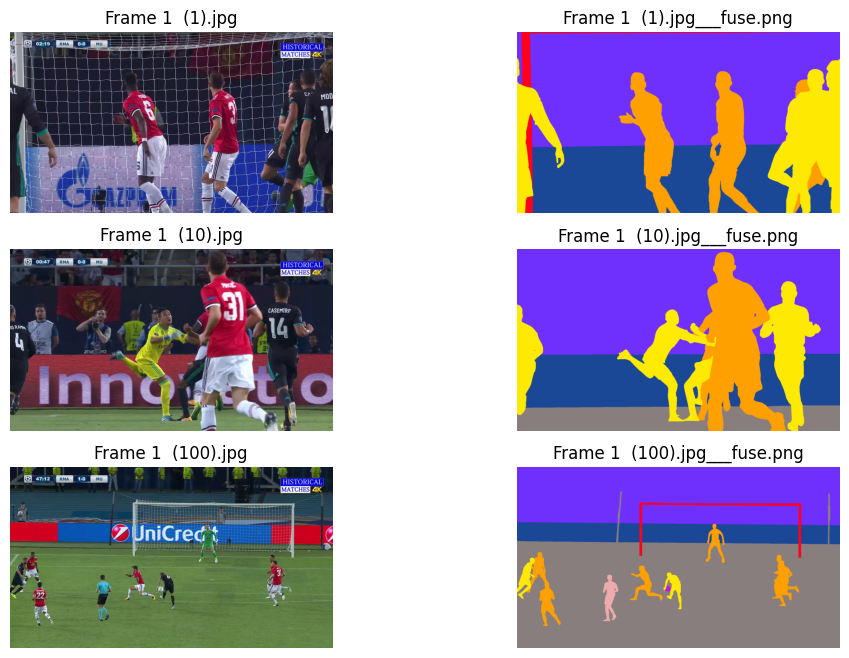

In [7]:
plt.figure(figsize=(12, 8))
for i in range (3):
    image=cv2.imread(df["Images paths"][i])
    mask=cv2.imread(df["Masks paths"][i])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_name = os.path.basename(df["Images paths"][i])
    mask_name = os.path.basename(df["Masks paths"][i])
    
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)

    # Create a subplot for each mask
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(mask_name)

#plt.tight_layout()
plt.show()

## Images prepocessing 

The first stage for a computer vision project is the preprocessing of the data. In this stage, I prepare the data I have using some techniques to be ready for processing. As our data here is considered as visual data, so. it has different techniques to deal with it than preprocessing written data. The preprocessing may include and not limited to :


- Resizing: The data may contain large images. Large images may have more details but when processing them, they will take a lot of time to process, require computational power, take huge memory, and maybe contain unnecessary information. In addition, most image processes like Neural networks, Convolutional neural networks, or pre-trained models require fixed input sizes.
-Normalization: It is a process of scaling the pixel values of an image to a standard range (usually from 0 to 1 or -1 to 1).


In [8]:
output_shape = (256,256)
images=[]
masks=[]
for i, m in zip(df['Images paths'], df['Masks paths']):
  img = Image.open(i)
  msk=Image.open(m)
  img_resized = np.array(img.resize(output_shape))
  image = img_to_array(img_resized)
  image = image/255.
  msk_resized =np.array(msk.resize(output_shape,resample=Image.NEAREST))
  images.append(image)
  masks.append(msk_resized)

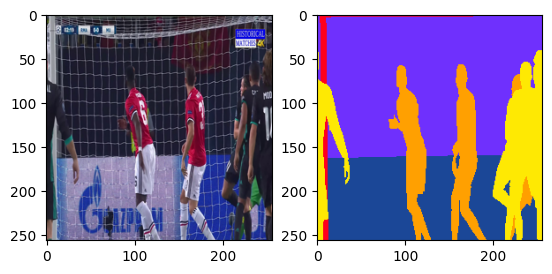

In [11]:
image=cv2.imread(df["Images paths"][0])
mask=cv2.imread(df["Masks paths"][0])
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
mask= cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)#cv2 read the images in the BGR format , in order to show it with matplot library I should convert it to RGB
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(masks[0])

## One hot Encoding 
It's a preprocess technique to represent categorical features or classes.This type of encoding creates a new binary feature for each possible category and assigns a value of 1 to the feature of each sample that corresponds to its original category. In this task, we need to classify 11 classes.
<br/>
1- find a color map : It differntiate from project to project and the given data. Some projects you will have the color map already or sometimes you get it from the masks images by extracting the unique colors in the masks. Color map is usually a dictionary that include the labels or the number of classes and the corresponding colors for each label or class.
<br/>
2- using the color map, we convert our masks that consists of the colors numbers like (2,86,200) to labeled masks where every pixels value becomes a labels like convert (2,86,200) -----> label 1 and so on and apply that to all the pixel values.
<br/> 
3- separte each class to separte channels or layers 


### 1- Finding the color Map 

In [12]:
masks=np.array(masks)

In [13]:
color_map=np.unique(masks.reshape(-1, 4), axis=0)
color_map

array([[  0,   0,   0, 255],
       [ 27,  71, 151, 255],
       [111,  48, 253, 255],
       [137, 126, 126, 255],
       [201,  19, 223, 255],
       [238, 171, 171, 255],
       [254, 233,   3, 255],
       [255,   0,  29, 255],
       [255, 159,   0, 255],
       [255, 160,   1, 255],
       [255, 235,   0, 255]], dtype=uint8)

In [14]:
def generate_color_to_label(png_mask):
    # Reshape the 3D RGBA mask into a 2D array where each row represents a pixel's RGB values
    unique_colors = np.unique(png_mask.reshape(-1, 4), axis=0)
    
    # Create a dictionary where keys are tuples of RGB values, and values are unique labels
    color_to_label = {tuple(color[:4]): label for label, color in enumerate(unique_colors)}

    return color_to_label

In [16]:
mk= generate_color_to_label(masks)
mk

{(0, 0, 0, 255): 0,
 (27, 71, 151, 255): 1,
 (111, 48, 253, 255): 2,
 (137, 126, 126, 255): 3,
 (201, 19, 223, 255): 4,
 (238, 171, 171, 255): 5,
 (254, 233, 3, 255): 6,
 (255, 0, 29, 255): 7,
 (255, 159, 0, 255): 8,
 (255, 160, 1, 255): 9,
 (255, 235, 0, 255): 10}

In [18]:
type(mk)

dict

In [19]:
mk.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### 2- Apply the color map and replace the colors values with labels 

In [20]:
mask_numeric = np.zeros(masks.shape[:-1], dtype=np.uint8)

for label, color in enumerate(mk.keys()):
    indices = np.all(masks[:, :, :, :4] == np.array(color), axis=-1)
    mask_numeric[indices] = label

In [21]:
np.unique(mask_numeric)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [22]:
mask_numeric

array([[[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       ...,

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [3, 3, 3, ..., 

In [23]:
mask_numeric.shape

(100, 256, 256)

### 3- Separate into 11 channel each channel for a class 

In [24]:
mask_categorical = to_categorical(mask_numeric, num_classes=11)

In [25]:
mask_categorical.shape

(100, 256, 256, 11)

## 3.Split the data into training, validation and testing dataset

In [26]:
X=np.array(images)
y=np.array(mask_categorical)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
X_trainn,X_val,y_trainn,y_val=train_test_split(X_train,y_train,test_size=0.2)
X_trainn.shape,y_trainn.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((64, 256, 256, 3),
 (64, 256, 256, 11),
 (16, 256, 256, 3),
 (16, 256, 256, 11),
 (20, 256, 256, 3),
 (20, 256, 256, 11))

## UNET architecture 

It's a deep learning architecture that firstly used in boimedical image segmentation. It consists of 3 major parts:
<br/>
1- Encoder 
<br/>
2- Bottle Neck 
<br/>
3- Decoder 
<br/>
4- Skip Connections

1- Encoder (The what)
It's a convolutional neural network that aims to extract the main features in images without details or specific shapes. It consists of 3 double layers of convolutional layes with ReLU activation function that followed be max pooling to reduce the dimentions and extract the features 

2- Bottle neck:
It's the deepest layer in the UNET architecture which is like a bridge between the downsampling (encoder) and upsampling (decoder) parts.It often consists of multiple convolutional layers that capture complex features.

3- Decoder (The where)
It's the upsampling part of the network.It takes the features generated by the bottleneck and gradually increases the spatial resolution. This is often achieved through transposed convolutions (also known as deconvolutions or upsampling) and concatenation with feature maps from skip connections. The goal is to reconstruct a high-resolution output that aligns with the input.

4- Skip Connections
They are connections that skip one or more layers and directly link the encoder's output to the corresponding decoder's input.These connections help to preserve high-resolution information lost during downsampling.They facilitate the flow of detailed spatial information from the encoder to the decoder.

For more information: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

**Note** : There are some added layers to help the model normalize better 

In [27]:
# Input layer
inputs = Input((256, 256, 3))

#Encoder part 
c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.25)(c1)
c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.25)(c2)
c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.25)(c3)
c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.25)(c4)
c4 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottle Neck layer 
c5 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

#Decoder Part
u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = BatchNormalization()(u6)   # Skip Connection
u6 = concatenate([u6, c4])
u6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
u6 = Dropout(0.1)(u6)
u6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(u6)
u7 = BatchNormalization()(u7)
u7 = concatenate([u7, c3])
u7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
u7 = Dropout(0.1)(u7)
u7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(u7)
u8 = BatchNormalization()(u8)
u8 = concatenate([u8, c2])
u8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
u8 = Dropout(0.1)(u8)
u8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(u8)
u9 = BatchNormalization()(u9)
u9 = concatenate([u9, c1])
u9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
u9 = Dropout(0.1)(u9)
u9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)

outputs = Conv2D(11, (1, 1), activation="softmax")(u9)


In [181]:
model=Model(inputs=[inputs],outputs=[outputs])

In [182]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 64)         0         ['batch_normalization_18

In [183]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy", metrics=[MeanIoU(num_classes=11), 'accuracy'])

In [184]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [185]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_trainn))
        image = X_trainn[id]
        mask = y_trainn[id]
        pred_mask=model.predict(np.expand_dims(image, axis=0))[0]
 
        
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,3,2)
        mask_colored = np.argmax(mask, axis=-1)
        show_image(mask_colored)
        
        plt.subplot(1,3,3)
        pred_mask_colored = np.argmax(pred_mask, axis=-1)
        show_image(pred_mask_colored)
        
        plt.tight_layout()
        plt.show()

In [186]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [188]:
cbs = [ShowProgress(),early_stopping]

Epoch 1/25
1/1 [==============================] - 1s 1s/steploss: 1.3150 - mean_io_u_1: 0.4545 - accuracy: 0.628


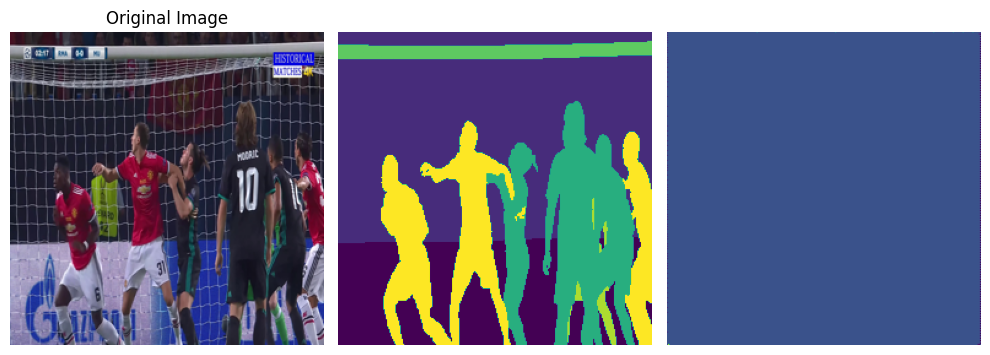

8/8 [==============================] - 254s 26s/step - loss: 1.3150 - mean_io_u_1: 0.4545 - accuracy: 0.6284 - val_loss: 349.1067 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4035
Epoch 2/25
1/1 [==============================] - 1s 749ms/steps: 0.7407 - mean_io_u_1: 0.4545 - accuracy: 0.745


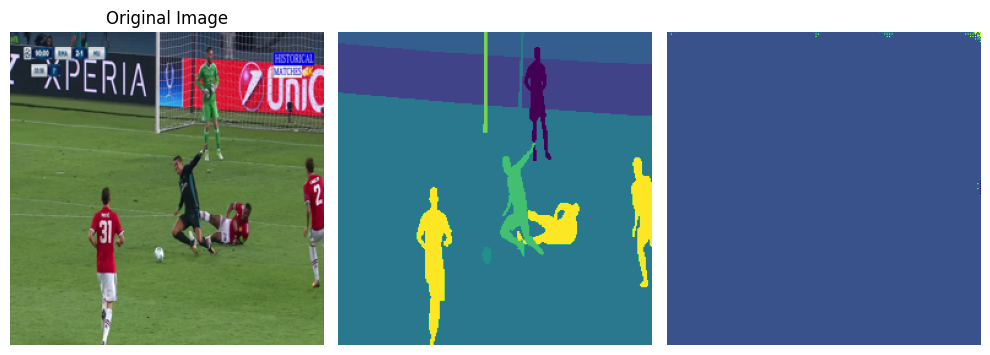

8/8 [==============================] - 200s 25s/step - loss: 0.7407 - mean_io_u_1: 0.4545 - accuracy: 0.7453 - val_loss: 39.3523 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4032
Epoch 3/25
1/1 [==============================] - 1s 764ms/steps: 0.6135 - mean_io_u_1: 0.4545 - accuracy: 0.787


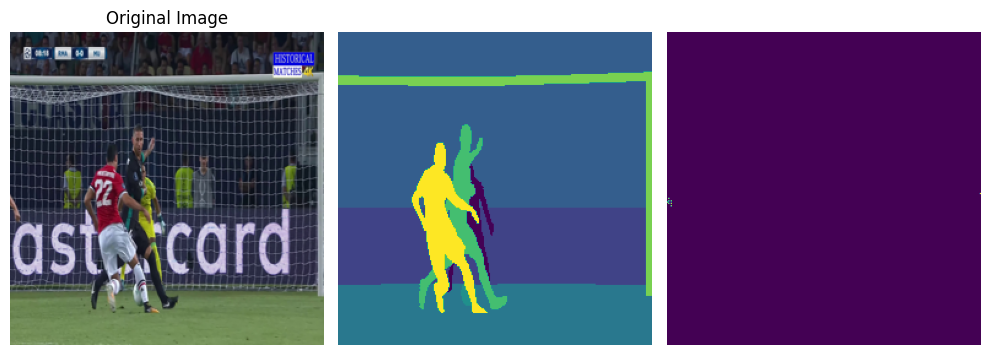

8/8 [==============================] - 195s 25s/step - loss: 0.6135 - mean_io_u_1: 0.4545 - accuracy: 0.7876 - val_loss: 24.7845 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4041
Epoch 4/25
1/1 [==============================] - 1s 729ms/steps: 0.5533 - mean_io_u_1: 0.4545 - accuracy: 0.810


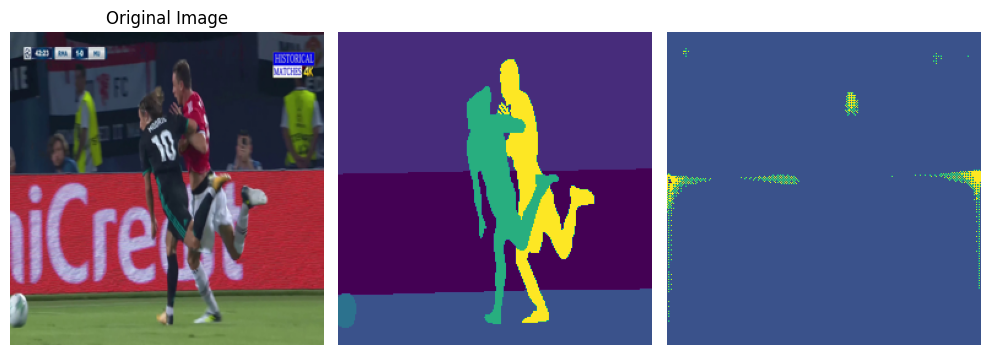

8/8 [==============================] - 194s 24s/step - loss: 0.5533 - mean_io_u_1: 0.4545 - accuracy: 0.8106 - val_loss: 8.1997 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4070
Epoch 5/25
1/1 [==============================] - 1s 743ms/steps: 0.4862 - mean_io_u_1: 0.4545 - accuracy: 0.836


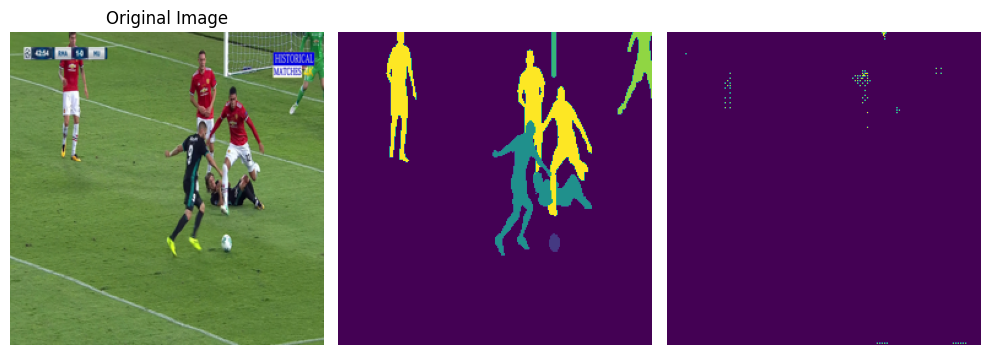

8/8 [==============================] - 201s 26s/step - loss: 0.4862 - mean_io_u_1: 0.4545 - accuracy: 0.8367 - val_loss: 7.2680 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4086
Epoch 6/25
1/1 [==============================] - 1s 755ms/steps: 0.4323 - mean_io_u_1: 0.4545 - accuracy: 0.855


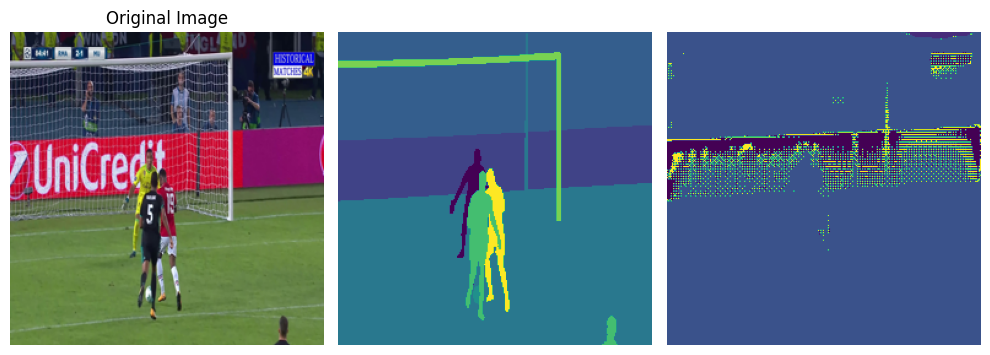

8/8 [==============================] - 195s 25s/step - loss: 0.4323 - mean_io_u_1: 0.4545 - accuracy: 0.8552 - val_loss: 3.7602 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.4226
Epoch 7/25
1/1 [==============================] - 1s 742ms/steps: 0.4020 - mean_io_u_1: 0.4545 - accuracy: 0.865


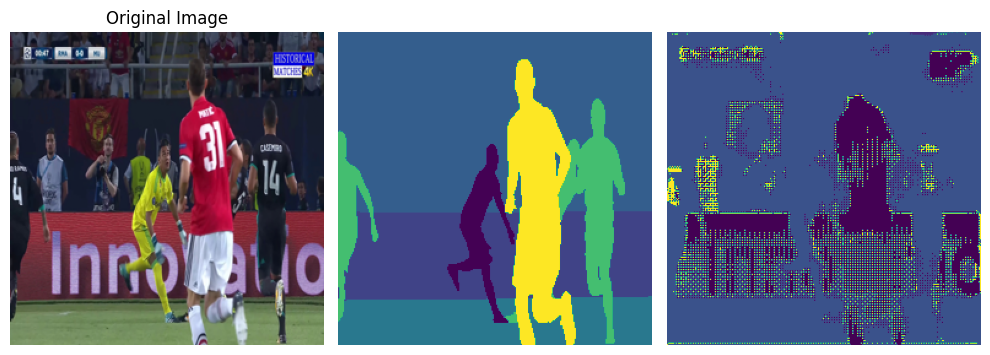

8/8 [==============================] - 195s 25s/step - loss: 0.4020 - mean_io_u_1: 0.4545 - accuracy: 0.8658 - val_loss: 3.2616 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.5010
Epoch 8/25
1/1 [==============================] - 1s 759ms/steps: 0.3818 - mean_io_u_1: 0.4545 - accuracy: 0.873


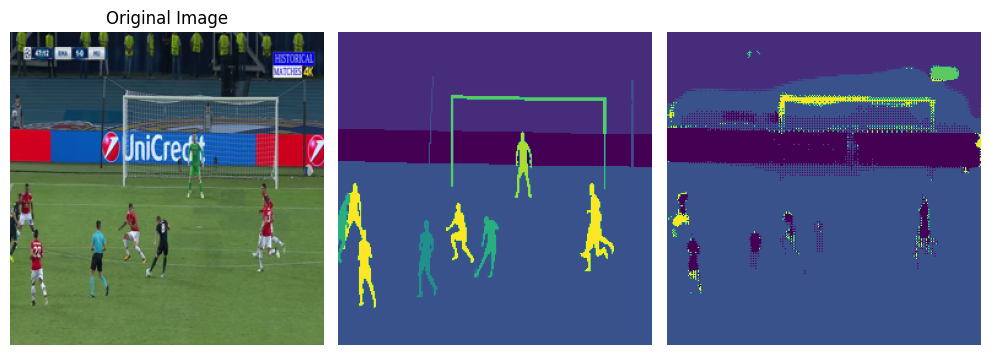

8/8 [==============================] - 196s 25s/step - loss: 0.3818 - mean_io_u_1: 0.4545 - accuracy: 0.8733 - val_loss: 1.6435 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.6580
Epoch 9/25
1/1 [==============================] - 1s 743ms/steps: 0.3389 - mean_io_u_1: 0.4545 - accuracy: 0.890


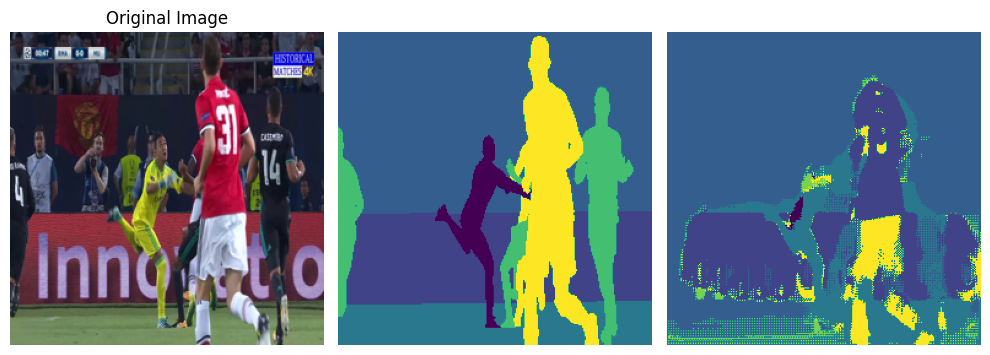

8/8 [==============================] - 196s 25s/step - loss: 0.3389 - mean_io_u_1: 0.4545 - accuracy: 0.8904 - val_loss: 2.6573 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.5252
Epoch 10/25
1/1 [==============================] - 1s 740ms/steps: 0.3521 - mean_io_u_1: 0.4545 - accuracy: 0.884


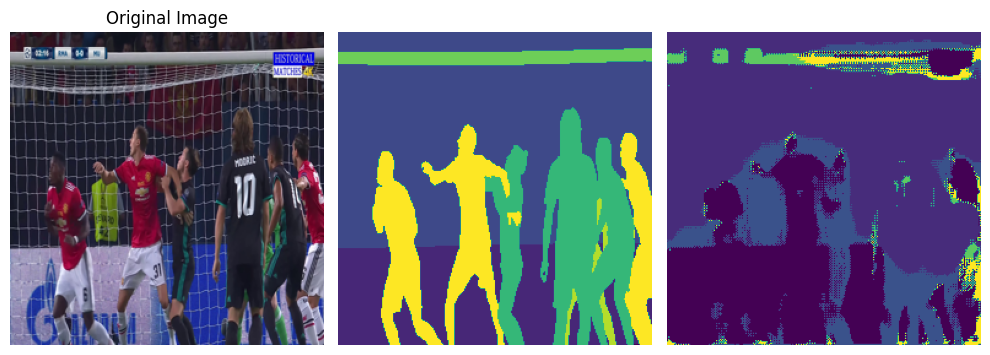

8/8 [==============================] - 195s 25s/step - loss: 0.3521 - mean_io_u_1: 0.4545 - accuracy: 0.8848 - val_loss: 1.3874 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.6958
Epoch 11/25
1/1 [==============================] - 1s 763ms/steps: 0.3124 - mean_io_u_1: 0.4545 - accuracy: 0.900


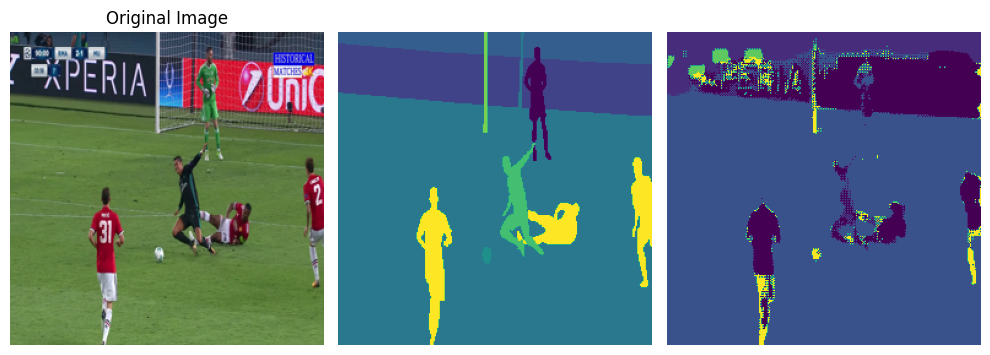

8/8 [==============================] - 201s 26s/step - loss: 0.3124 - mean_io_u_1: 0.4545 - accuracy: 0.9007 - val_loss: 1.1014 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7181
Epoch 12/25
1/1 [==============================] - 1s 889ms/steps: 0.2970 - mean_io_u_1: 0.4545 - accuracy: 0.903


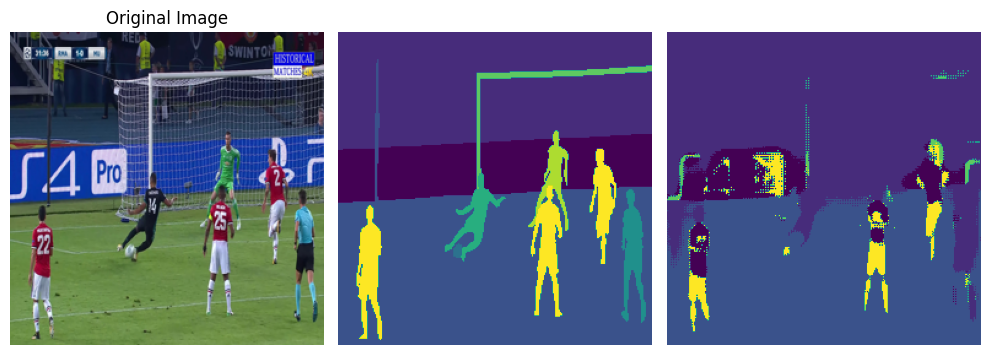

8/8 [==============================] - 194s 24s/step - loss: 0.2970 - mean_io_u_1: 0.4545 - accuracy: 0.9035 - val_loss: 1.6044 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.6937
Epoch 13/25
1/1 [==============================] - 1s 737ms/steps: 0.2753 - mean_io_u_1: 0.4545 - accuracy: 0.913


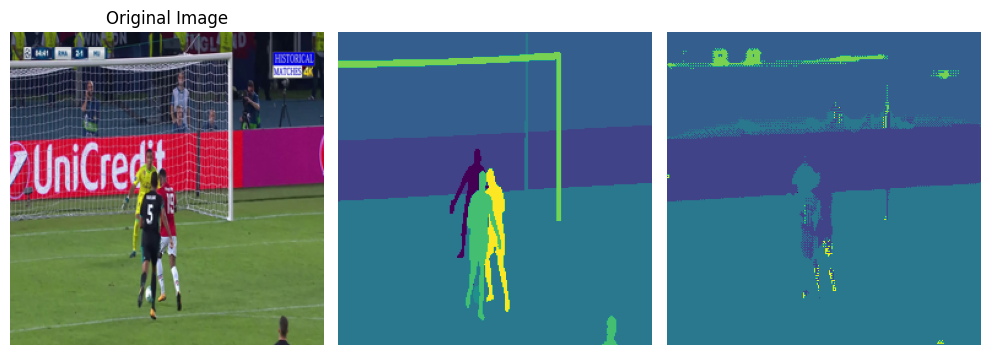

8/8 [==============================] - 201s 25s/step - loss: 0.2753 - mean_io_u_1: 0.4545 - accuracy: 0.9133 - val_loss: 0.9680 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7687
Epoch 14/25
1/1 [==============================] - 1s 735ms/steps: 0.2703 - mean_io_u_1: 0.4545 - accuracy: 0.915


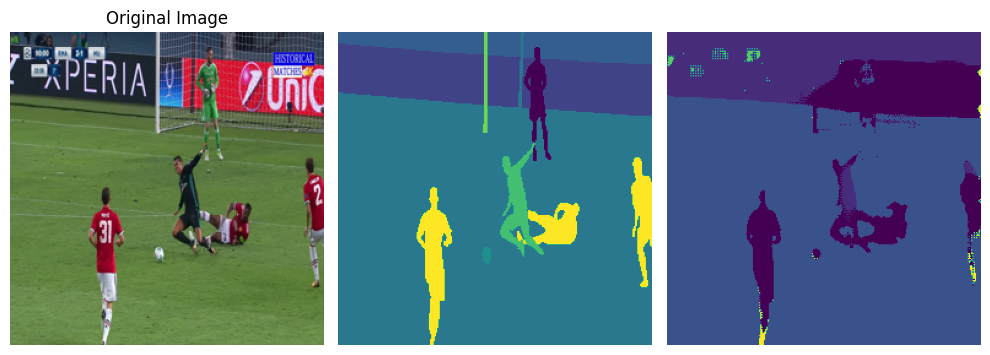

8/8 [==============================] - 199s 25s/step - loss: 0.2703 - mean_io_u_1: 0.4545 - accuracy: 0.9152 - val_loss: 1.5469 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7471
Epoch 15/25
1/1 [==============================] - 1s 750ms/steps: 0.2560 - mean_io_u_1: 0.4545 - accuracy: 0.918


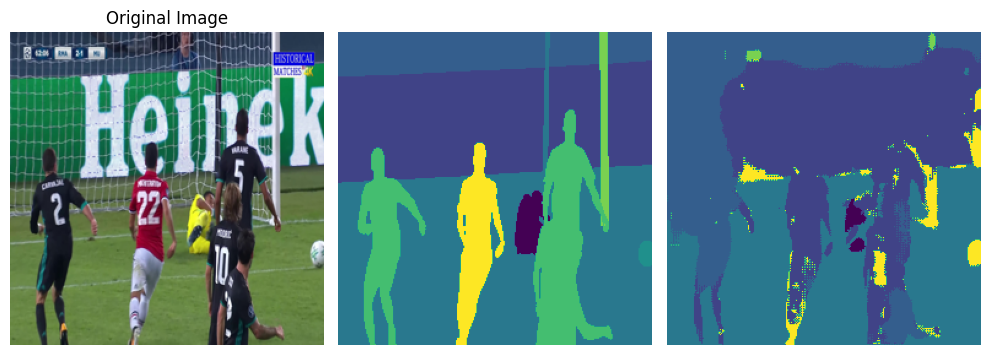

8/8 [==============================] - 192s 24s/step - loss: 0.2560 - mean_io_u_1: 0.4545 - accuracy: 0.9185 - val_loss: 1.0889 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7667
Epoch 16/25
1/1 [==============================] - 1s 726ms/steps: 0.2330 - mean_io_u_1: 0.4545 - accuracy: 0.926


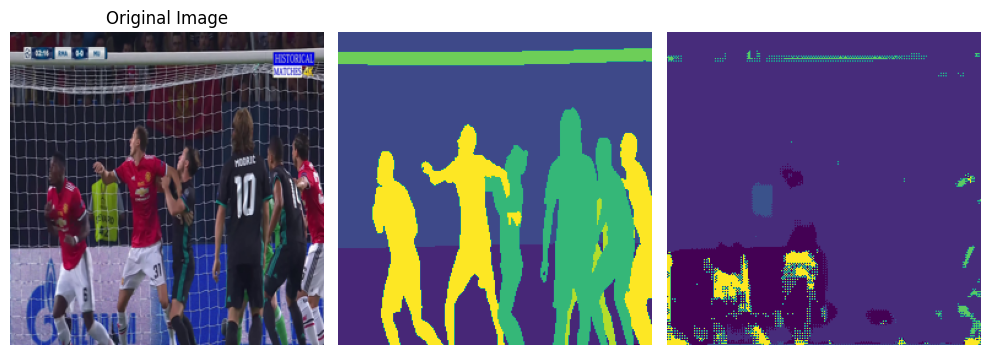

8/8 [==============================] - 191s 24s/step - loss: 0.2330 - mean_io_u_1: 0.4545 - accuracy: 0.9266 - val_loss: 1.2624 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7772
Epoch 17/25
1/1 [==============================] - 1s 730ms/steps: 0.2426 - mean_io_u_1: 0.4545 - accuracy: 0.923


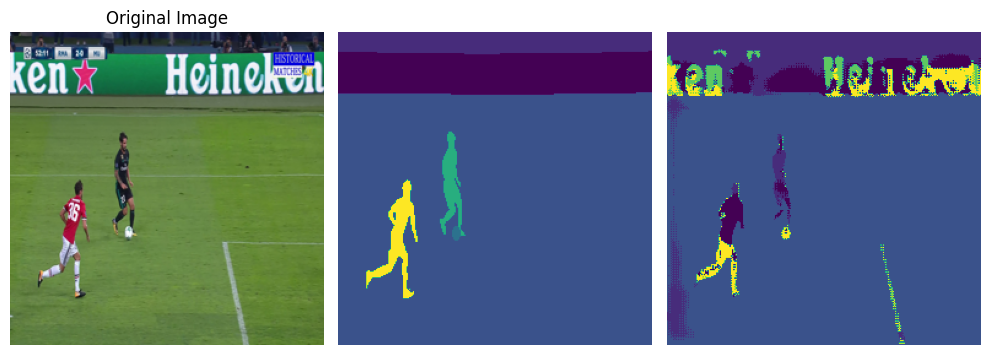

8/8 [==============================] - 199s 25s/step - loss: 0.2426 - mean_io_u_1: 0.4545 - accuracy: 0.9230 - val_loss: 1.1513 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.6952
Epoch 18/25
1/1 [==============================] - 1s 731ms/steps: 0.2389 - mean_io_u_1: 0.4545 - accuracy: 0.923


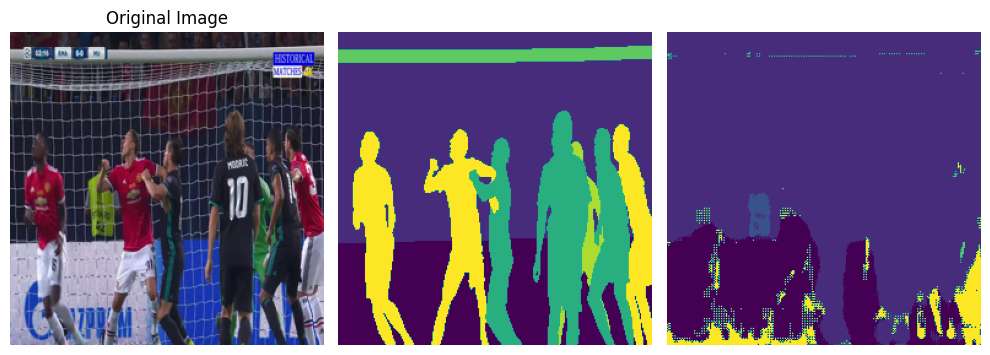

8/8 [==============================] - 192s 24s/step - loss: 0.2389 - mean_io_u_1: 0.4545 - accuracy: 0.9239 - val_loss: 1.4619 - val_mean_io_u_1: 0.4545 - val_accuracy: 0.7419


In [189]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_trainn, y_trainn, epochs=25,batch_size=8,validation_data=(X_val, y_val),callbacks=cbs)